# 1. 自注意力

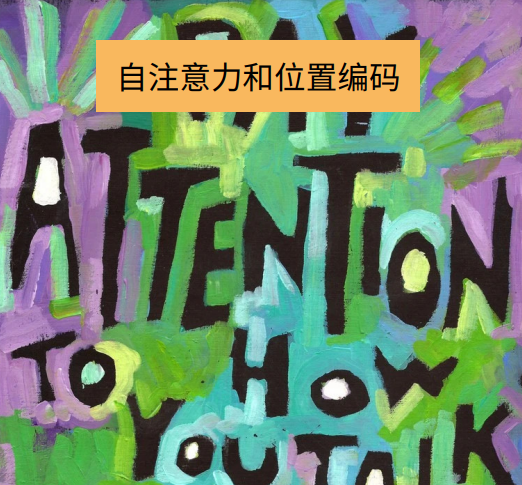

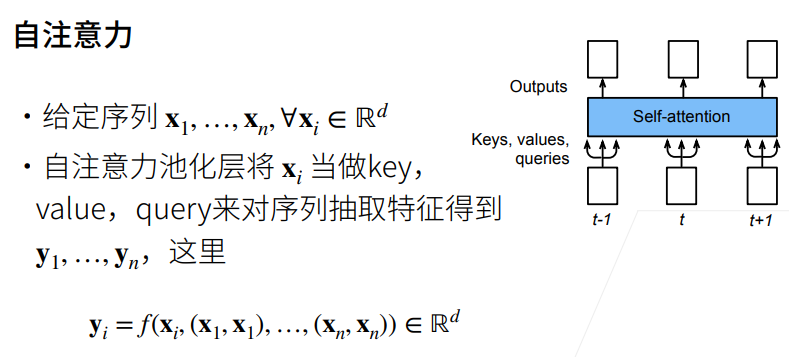

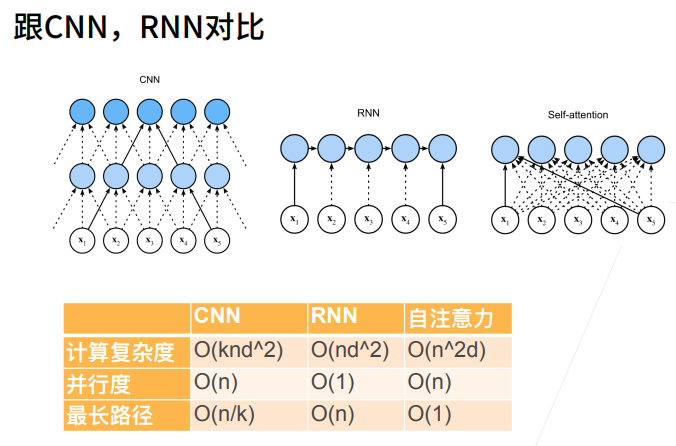

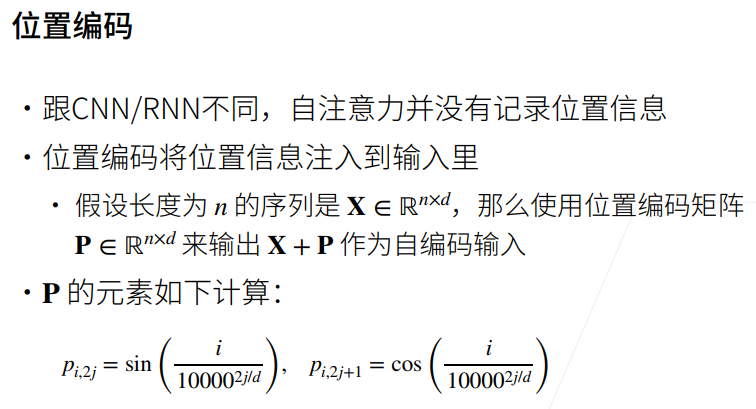

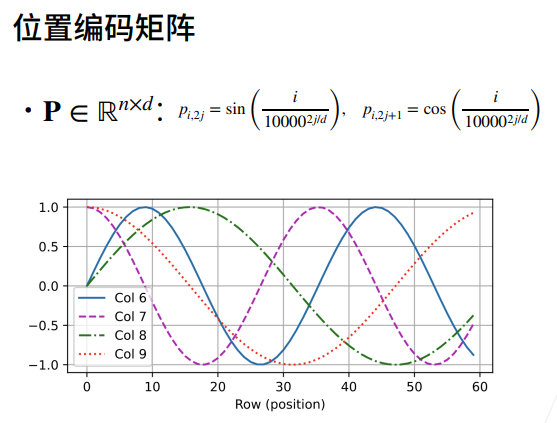

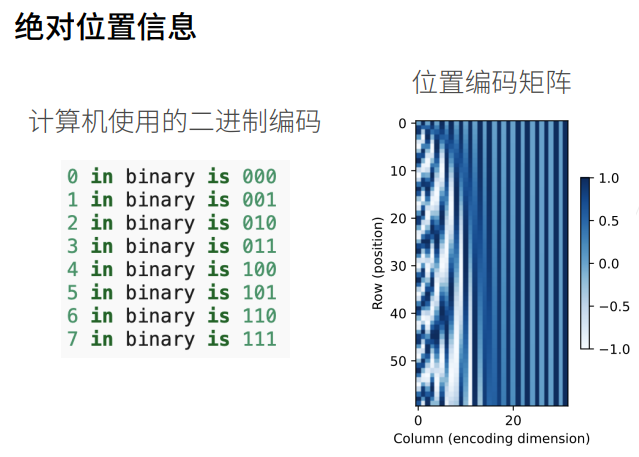

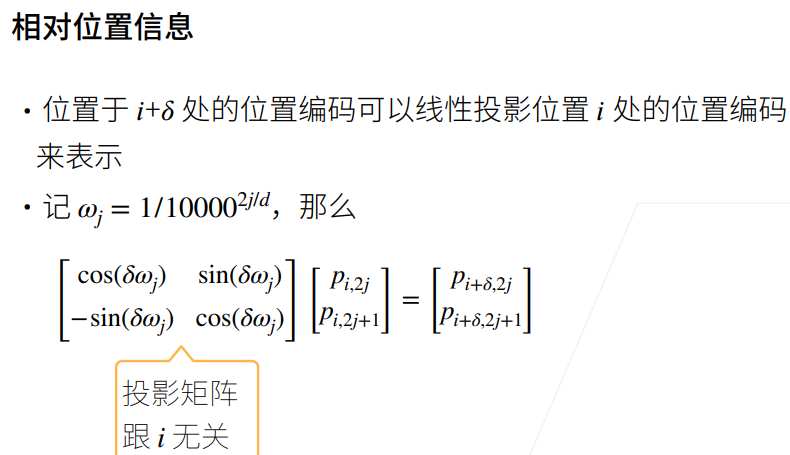

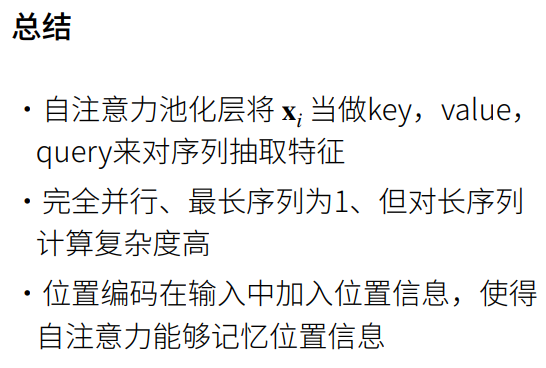

相对位置信息，保证了两个词无论出现在句子的前后哪个地方，他们只要相对位置确定，那么相对的信息也是确定的。这也保证一个句子不管怎么切分&送进去训练都是ok的。

# 2. 自注意力

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                  num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

$$P_{i,2j} = sin(\frac{i}{10000^{2j/d}})$$

$$P_{i,2j+1} = cos(\frac{i}{10000^{2j/d}})$$

In [2]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        # max_len就是n，然后i的值从0开始、到max_len为止
        # num_hiddens就是上文中的d，j的值也是从0开始到num_hiddens为止
        self.P = torch.zeros((1, max_len, num_hiddens))
        
        # X为从0到max_len的，step为1的序列，也即公式中的i
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)
        # X再除以分母中的10000^(2j/d)
        X = X / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        
        # 先把所有的都置成sin，再把
        self.P[:,:,0::2] = torch.sin(X)
        self.P[:,:,1::2] = torch.cos(X)
        
    def forward(self, X):
        # 将位置信息P直接加到X上面
        # 第一维上batch_size，虽然上面的P设置为1，但是可以通过广播将其复制成多个batch的版本
        # 这里相当于提前计算了长度为1000的位置编码，这里再取出需要的前“句子长度”个值就ok了
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)  # 另外，需要再做一个dropout的正则化，来避免模型对P太过敏感

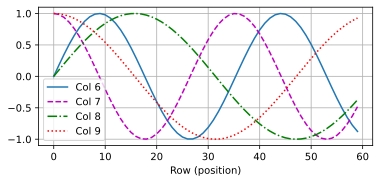

In [3]:
# 行代表标记在序列中的位置，列代表位置编码的不同维度
encoding_dim, num_steps = 32, 60

# 这里表示d的值为32
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()

X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]

# 这里绘制了当j为6、7、8、9的四个曲线
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
        figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])    

In [4]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


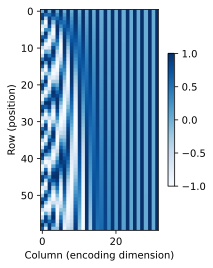

In [5]:
# 在编码维度上降低频率
P = P[0, :, :].unsqueeze(0).unsqueeze(0)

d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                 ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')